<hr><h1>1.<u> Introduction</u> </h1>

>  <h4>The goal of this notebook is to build a machine learning pipeline that analyzes user behavior — like session activity, device information, location, and traffic source — and predicts how much a user might spend in a session.</h4>

<hr>

<h2><u>1.1 Approach Taken</u></h2>
<hr>
<ol>
<h4><li>Data Loading and Initial Exploration</li></h4>
    <ul>
        <li>Imported and explored all the datasets: `train_data.csv and test_data.csv`.</li>
        <li>Checked for data shapes, column types, missing values, and categorical vs numerical columns.</li>
        <li>Gained an initial understanding of the problem and the distribution of the target variable `purchaseValue`.</li>
    </ul>
    
<h4><li>Exploratory Data Analysis (EDA)</li></h4>
    <ul>
        <li>Performed detailed visual and statistical analysis:</li>
            <ul>
                <li>Distribution of users across `countries, continents, and regions`.</li>
                <li>Correlation heatmaps and scatter plots to identify important numerical relationships.</li>
                <li>Focused on user behavior patterns like session frequency, device/browser type, and traffic sources.</li>
            </ul>
    </ul>
    
<h4><li>Feature Engineering</li></h4>
    <ul>
        <li>Created new features like:</li>
        <ul>
            <li>hour, dayofweek, and month from sessionStart feature.</li>
            <li> userAvgPurchase to capture historical purchase behavior.</li>
            <li>hitsPerPageview to normalize total hits over page views.</li>
            <li>Handled duplicates and filled missing values logically.</li>
        </ul>
    </ul>

<h4><li>Data Preprocessing</li></h4>
    <ul>
        <li>Built separate pipelines for:</li>
        <ul>
            <li>Numerical data: Median imputation, polynomial features, and scaling.</li>
            <li>Categorical data: Mode imputation and One-Hot Encoding.</li>
            <li>Combined them using a ColumnTransformer and applied consistently across models.</li>
        </ul>
    </ul>

<h4><li>Model Development</li></h4>
<ul>
<li>Trained and compared multiple regression models:</li>
    <ul> 
    <li>Dummy Regressor</li>
    <li>Linear Regression</li>
    <li>Ridge Regression</li>
    <li>XGBoost Regressor</li>
    </ul>
<li>Evaluated models using R² score, selecting `XGBoostRegressor` as the best performer.</li>
</ul>

<h4><li>Submission and Reporting</li></h4>
<ul>
<li>Final predictions were made using the best model (XGBoost).</li>
<li>Results saved in the required submission format for evaluation.</li>
</ul>
</ol>

<hr>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


<hr>
    <h1>2. <u>Library Imports</u> </h1>
<hr>

In [2]:
# Library for Visualization 
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_theme(style="whitegrid")

# SKlearn Utilities 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder , PolynomialFeatures 
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression , Ridge
import xgboost as xg
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

<hr>
    <h1>3. <u> Data Loading</u></h1>
<hr>

In [3]:
# Load Datasets 
dfTrain = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
dfTest = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')

<hr>
<h1>4.<u>  Exploratory Data Analysis (EDA)</u></h1>

<hr>

<h2> 4.1 Dataset Overview</h2>

<hr>


In [4]:
print("Train Shape:", dfTrain.shape)
print("Test Shape:", dfTest.shape)

Train Shape: (116023, 52)
Test Shape: (29006, 51)



<h4>Observation</h4>

* The training data is spread over 116023 rows and 52 columns.
* The test data is spread over 29006 rows and 51 columns.
* `purchaseValue` column is the target column.
* We have to predict purchase value in test data using different ML models.

<h2> 4.2 Preview of Training Data </h2>

<hr>

In [5]:
dfTrain.head(20)

,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,...,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
0,NaN,0.0,Edge,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1500100799,Americas,False,1.0
1,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,1,not available in demo dataset,1495262065,Americas,False,1.0
2,True,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Organic Search,not available in demo dataset,6,not available in demo dataset,1508510328,Europe,False,NaN
3,NaN,0.0,Internet Explorer,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1483431838,Asia,False,1.0
4,True,88950000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,66,not available in demo dataset,1475804633,Americas,False,1.0
5,True,28000000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Referral,not available in demo dataset,48,not available in demo dataset,1505506252,Americas,False,NaN
6,NaN,80510000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Referral,not available in demo dataset,17,not available in demo dataset,1472053897,Americas,False,1.0
7,NaN,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_5,NaN,not available in demo dataset,...,not available in demo dataset,mobile,Organic Search,not available in demo dataset,1,not available in demo dataset,1490756441,Asia,True,1.0
8,True,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Organic Search,not available in demo dataset,4,not available in demo dataset,1495702257,Asia,False,NaN
9,NaN,0.0,Safari,not available in demo dataset,NaN,(not provided),medium,Region_1,NaN,not available in demo dataset,...,not available in demo dataset,mobile,Organic Search,not available in demo dataset,1,not available in demo dataset,1500868868,Asia,True,1.0


<h4>Observation</h4>

* At a first glance, data is seems to contain many `NaN` , `not available in demo dataset` ,etc across various feature(s).
* There is a need of good imputation strategy to make a data meaningfull.

<h2> 4.3 Data Types & Missing Values </h2>

<hr>

In [6]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 9   device.mobileDeviceBranding                   11

Numerical Columns: 14
Categorical Columns: 37


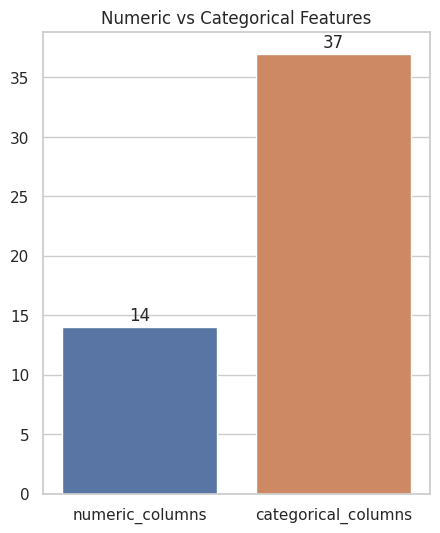

In [7]:
# Defining Numerical and Categorical Column Present in dataset 
numericColumns = dfTrain.select_dtypes(include=['int64','float64']).columns  #Numerical Columns present in Training Dataset
catColumns = dfTrain.select_dtypes(include=['object']).columns  #Categorical Columns present in Training Dataset
print(f"Numerical Columns: {len(numericColumns)}")
print(f"Categorical Columns: {len(catColumns)}")

# Plotting bar plot for numerical and categorical Columns 
plt.figure(figsize=(5,6))
bp = sns.barplot(x=['numeric_columns','categorical_columns'] , y=[len(numericColumns),len(catColumns)])
# bp = Bar Plot 
for container in bp.containers:
    bp.bar_label(container,label='edge' , padding = 2)
plt.title('Numeric vs Categorical Features')
plt.show()

11 columns have null values.


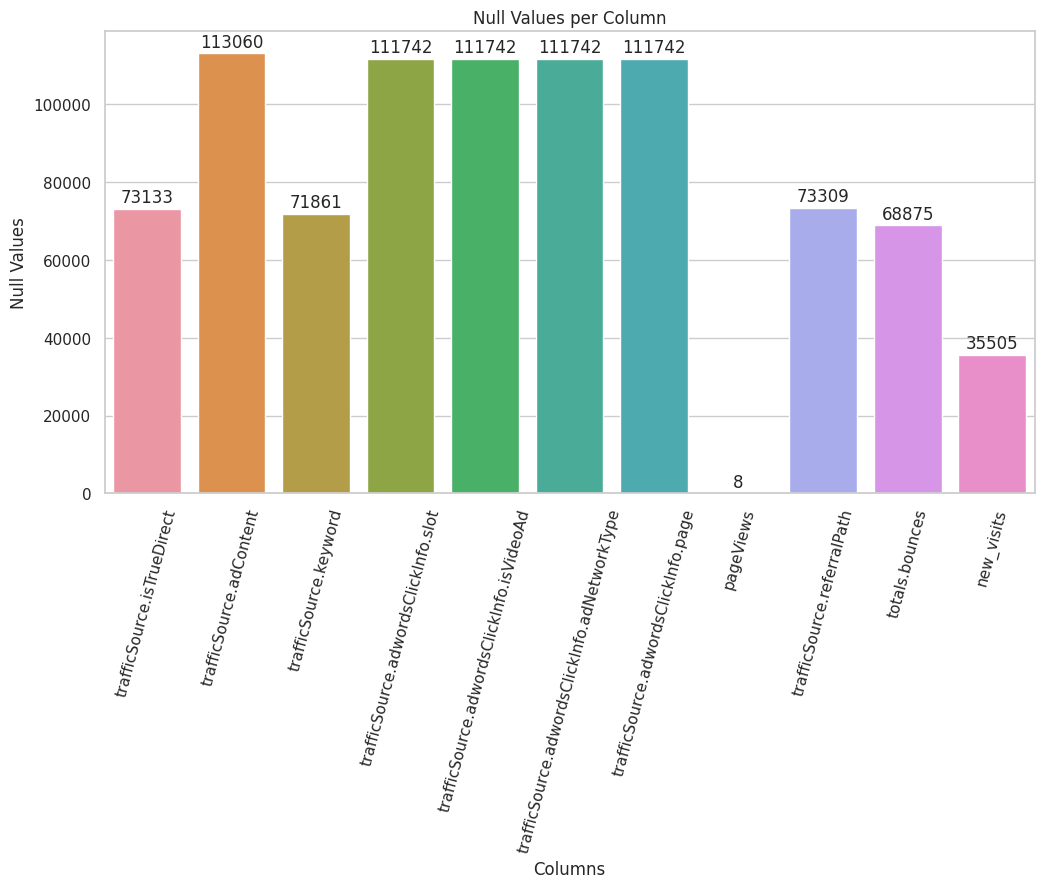

In [8]:
# Counting the null value(s) present in training data.
nullValues = dfTrain.isna().sum()
nullValues = nullValues[nullValues > 0]
print(f'{len(nullValues)} columns have null values.')

# Plotting bar chart to visualize properly.
plt.figure(figsize=(12,6))
ax = sns.barplot(x = nullValues.index , y = nullValues.values)
# ax = Null Value Bar Graph
plt.xlabel('Columns')
plt.xticks(rotation = 75)
plt.ylabel('Null Values')
plt.title('Null Values per Column')
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2)
plt.show()

<h4>Observations</h4>

* The training dataset consist of 14 numerical(including Target Column) and 37 categorical columns. 
* Several features, especially categorical ones like `trafficSource.adwordsClickInfo.adNetworkType, trafficSource.keyword, and trafficSource.adContent`, etc contain missing values.
* A bar plot was used to visualize the extent of missing data across columns which helped in deciding the imputation strategies to be performed, later during preprocessing.
* Identifying missing data early ensured appropriate handling and avoided leakage or bias in the model.

<h2>4.4 Statistical Summary</h2>
<hr>


In [9]:
dfTrain.describe().T

,count,mean,std,min,25%,50%,75%,max
purchaseValue,116023.0,2.656393e+07,2.051825e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.312950e+10
userId,116023.0,6.109436e+04,3.524076e+04,0.000000e+00,3.060350e+04,6.101400e+04,9.161650e+04,1.222760e+05
gclIdPresent,116023.0,3.701852e-02,1.888080e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
sessionNumber,116023.0,2.691311e+00,1.045161e+01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.470000e+02
totals.visits,116023.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
sessionId,116023.0,1.493429e+09,1.528798e+07,1.470035e+09,1.480066e+09,1.491646e+09,1.505079e+09,1.525157e+09
trafficSource.adwordsClickInfo.page,4281.0,1.019622e+00,1.745165e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00
pageViews,116015.0,8.412352e+00,1.434494e+01,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+01,4.690000e+02
locationZone,116023.0,8.000000e+00,0.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00
totals.bounces,47148.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [10]:
dfTrain.describe(include='object').T.sort_values(by='count',ascending=False)

,count,unique,top,freq
os,116023,18,Windows,39135
geoNetwork.city,116023,695,not available in demo dataset,60138
geoNetwork.subContinent,116023,23,Northern America,63596
trafficSource.medium,116023,7,organic,40654
browserMajor,116023,1,not available in demo dataset,116023
locationCountry,116023,193,United States,60369
device.browserSize,116023,1,not available in demo dataset,116023
socialEngagementType,116023,1,Not Socially Engaged,116023
geoNetwork.metro,116023,104,not available in demo dataset,60138
geoNetwork.networkLocation,116023,1,not available in demo dataset,116023


<h4>Observation</h4>

* 17 categorical features have single unique value.
* 7 features have high cardinality of unique value(s) excedding above 100.
* A clear Encoding strategy should be implemented to overcome this difference in uniques values across features.

<h2> 4.5 Target Distribution </h2>

<hr>



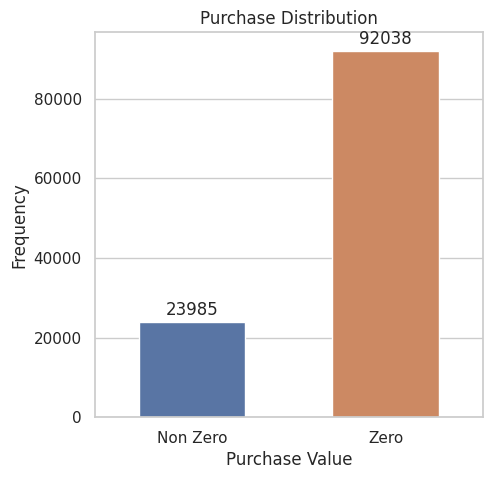

In [11]:
# Zero Purchase value 
zero = dfTrain[dfTrain['purchaseValue'] > 0]['purchaseValue']
nonZero = dfTrain[dfTrain['purchaseValue'] == 0]['purchaseValue']  # Have some purchase 

# Plotting bar chart to visualize it.
plt.figure(figsize=(5,5))
purchaseType = sns.barplot(x=['Non Zero' , 'Zero'] , y=[zero.count() , nonZero.count()] , width = 0.55)
for container in purchaseType.containers:
    purchaseType.bar_label(container,label='edge',padding=2)
plt.ylabel('Frequency')
plt.xlabel('Purchase Value')
plt.title('Purchase Distribution')
plt.show()

<h4>Observation</h4>

* Target Variable is heavily skewed toward `zero`.
* With over `>90K purchase value is zero` , indicating user didn't make any purchase.
* The remaining approx 24K purchase data forms the core learning for any model.

<h2>4.6 Understanding Data </h2>

<hr>




<hr><h4>Geographical Patterns </h4>

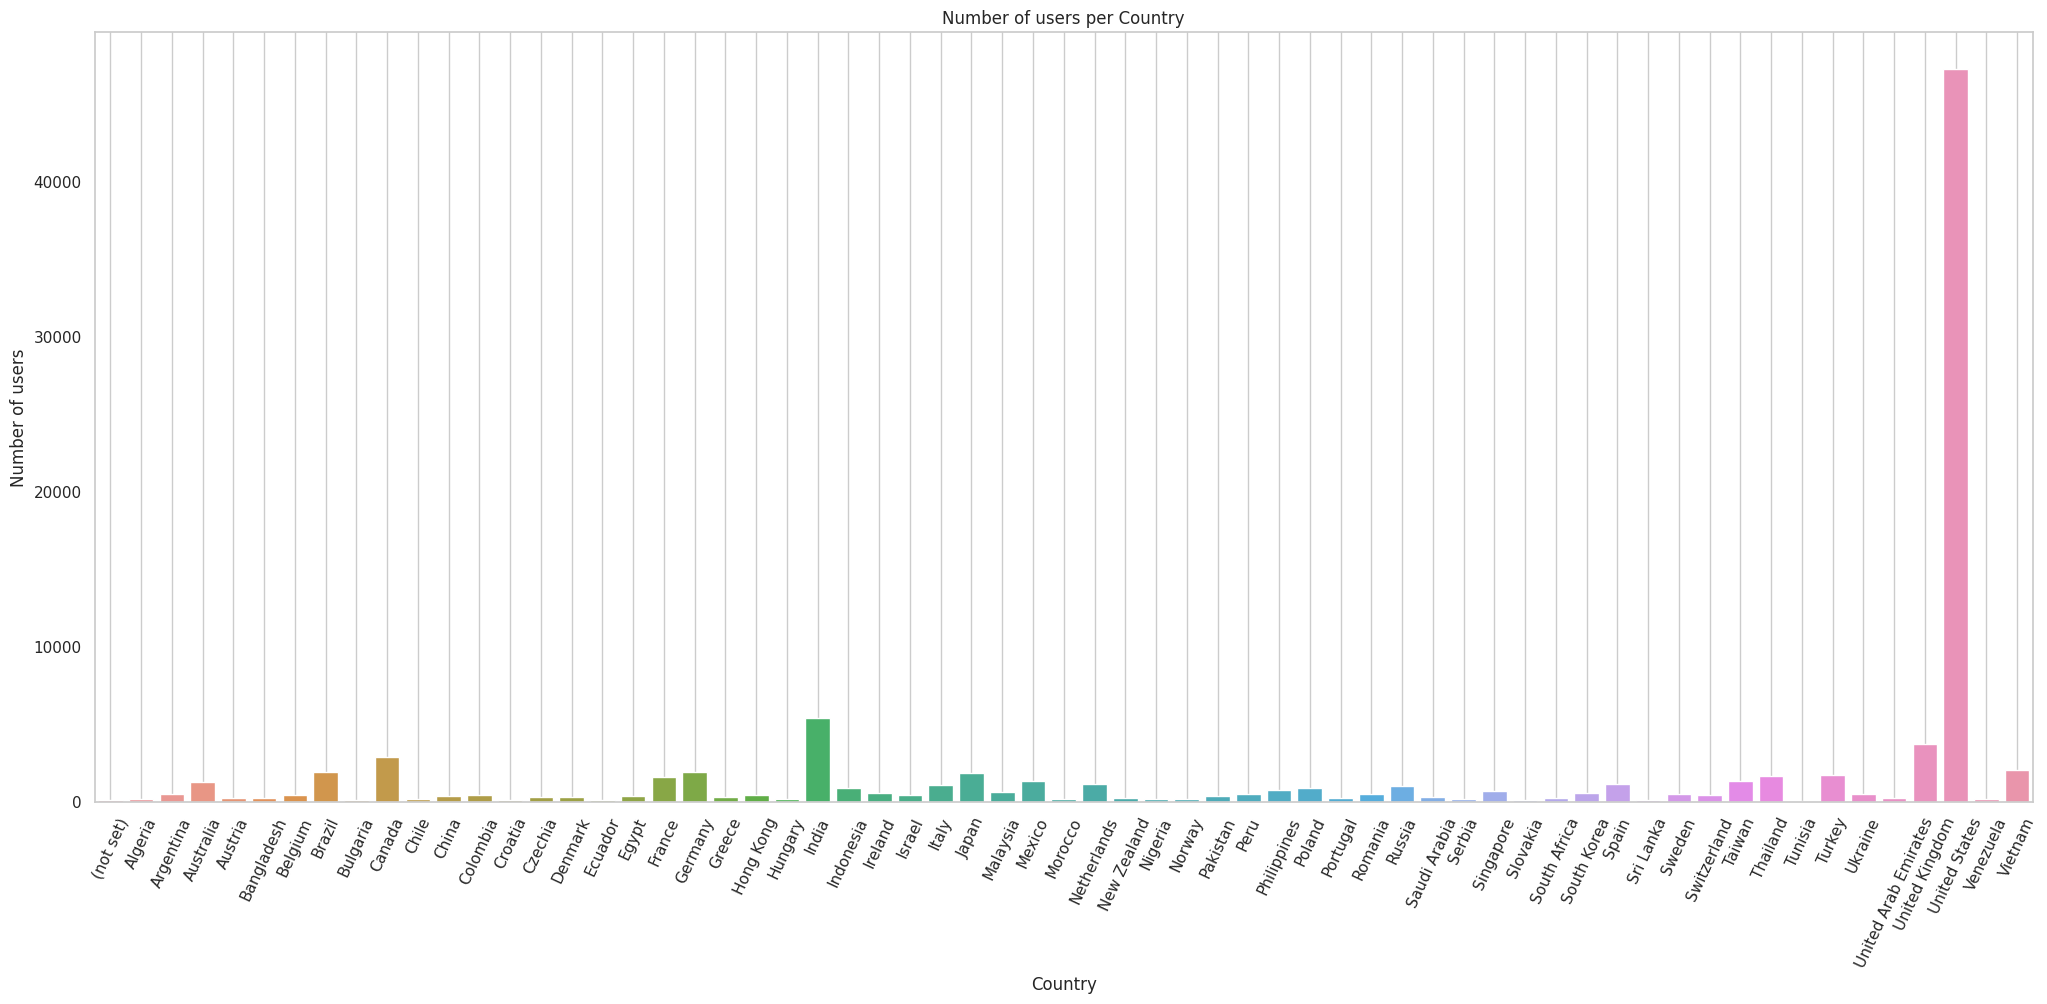

In [12]:
userByCountry = dfTrain.groupby(dfTrain['locationCountry'])['userId'].nunique()
majUserByCountry = userByCountry[userByCountry > 100]  # Number of countries which have a user base > 100.

# plotting a bar chart to visualize majUserByCountry properly 
plt.figure(figsize=(25,10))
sns.barplot(x=majUserByCountry.index , y = majUserByCountry)
plt.xticks(rotation=65)
plt.xlabel('Country')
plt.ylabel('Number of users')
plt.grid()
plt.title('Number of users per Country')
plt.show()

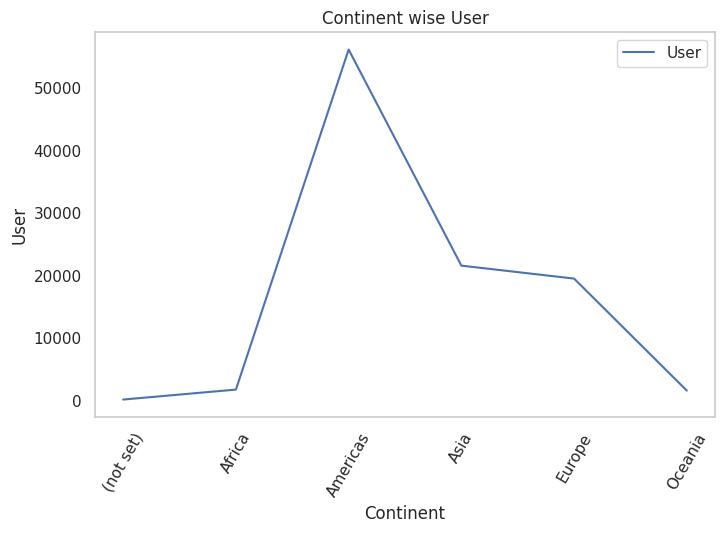

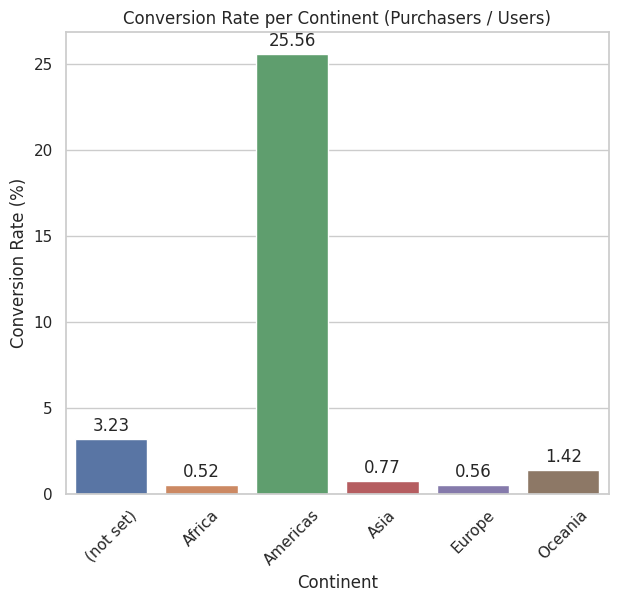

In [13]:
userByContinent = dfTrain.groupby(dfTrain['geoNetwork.continent'])['userId'].nunique().sort_values(ascending=False) # Number of unique users in each continent 

# Number of unique user ineach continent who actually made a purchase
purchaserByContinent = dfTrain[dfTrain['purchaseValue'] > 0].groupby(dfTrain['geoNetwork.continent'])['userId'].nunique().sort_values(ascending=False) 

# Creating dataframe to combine userByContinent and purchaserByContinent 
dfContinent = pd.DataFrame({
    'User' : userByContinent,
    'Purchaser' : purchaserByContinent
})

# Plotting a line chart to show number of unique user in each continent 
plt.figure(figsize=(8,5))
conlp1 = sns.lineplot(x=dfContinent.index , y=dfContinent['User'],label='User')  # conlp1 = userByContinent Line Plot 1 
plt.title("Continent wise User")
plt.xlabel('Continent')
plt.xticks(rotation=60)
plt.grid()
plt.show()

# Defining purchaser/user conversion rate for each continent 
dfContinent['ConversionRate'] = round((dfContinent['Purchaser'] / dfContinent['User']) * 100 , 2)

# Plotting bar chart for purchaser/user conversion rate 
plt.figure(figsize=(7, 6))
dfcbp = sns.barplot(x=dfContinent.index, y=dfContinent['ConversionRate'])  # dfcbp = dfContinentbarplot 
plt.xticks(rotation=45)
for container in dfcbp.containers:
    dfcbp.bar_label(container,label='edge',padding=3)
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Continent')
plt.title('Conversion Rate per Continent (Purchasers / Users)')
plt.show()

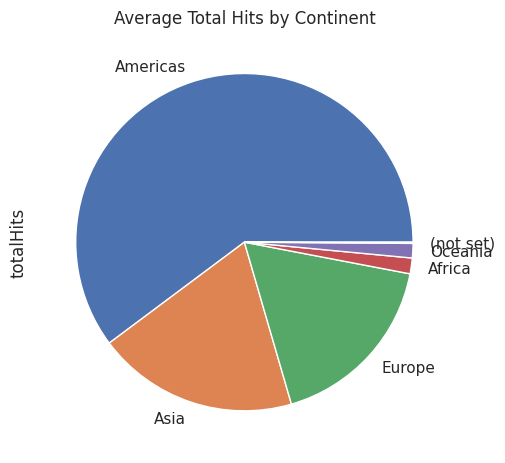

In [14]:
continentBytotalHits = dfTrain.groupby(dfTrain['geoNetwork.continent'])['totalHits'].count().sort_values(ascending=False)

continentBytotalHits.plot(kind='pie', legend=False)
plt.title('Average Total Hits by Continent')
plt.tight_layout()
plt.show()

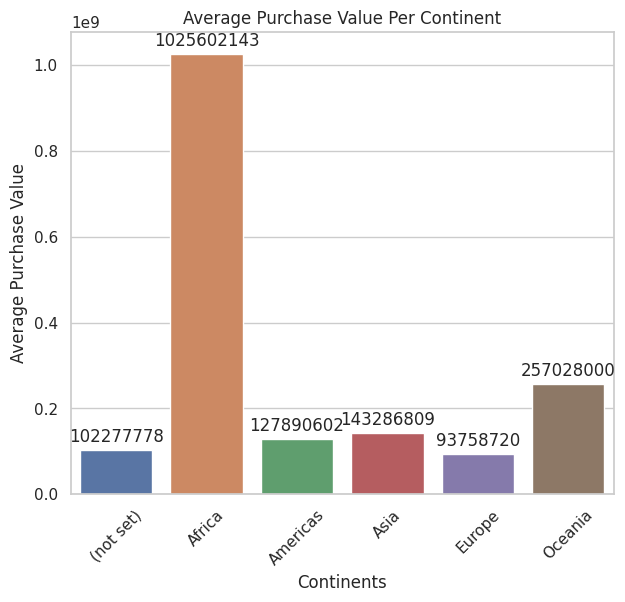

In [15]:
avgPurchase = dfTrain[(dfTrain['purchaseValue'] > 0)].groupby(['geoNetwork.continent'])['purchaseValue'].mean()

plt.figure(figsize=(7, 6))
apbp = sns.barplot(x=avgPurchase.index, y=avgPurchase.values)   # apbp = avgPurchase BarPlot 
plt.xticks(rotation=45)
for container in apbp.containers:
    apbp.bar_label(container,label='edge',padding=3 , fmt='%.0f')
plt.ylabel('Average Purchase Value')
plt.xlabel('Continents')
plt.title('Average Purchase Value Per Continent')
plt.show()

            TotalUsers  Purchasers
geoCluster                        
Region_1         23019        4722
Region_2         23294        4949
Region_3         23221        4835
Region_4         23278        4872
Region_5         23211        4607


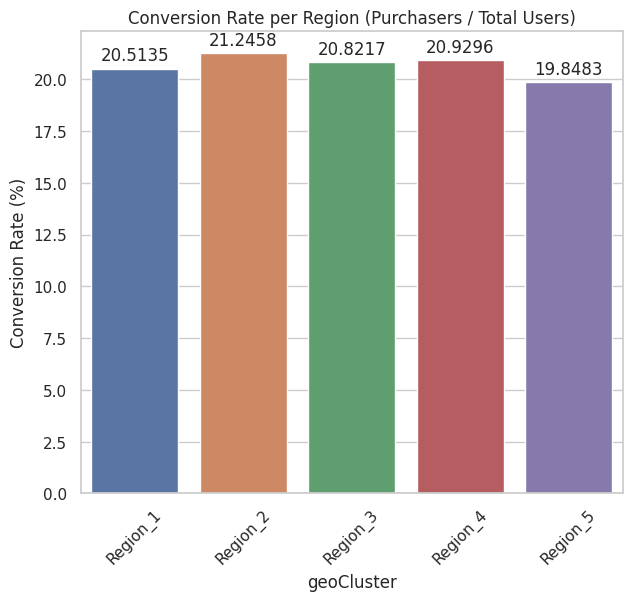

In [16]:
# Unique Users by each geoCLuster(s)
userByRegion = dfTrain.groupby(dfTrain['geoCluster'])['userId'].count()

# Unique User who actually purchase by each geoCLuster(s)
purchaseByRegion = dfTrain[dfTrain['purchaseValue'] > 0].groupby(dfTrain['geoCluster'])['userId'].count()

# DataFrame to define User and Purchaser in each GeoCluster 
dfRegion = pd.DataFrame({
    'TotalUsers': userByRegion,
    'Purchasers': purchaseByRegion
})
print(dfRegion)

#Calculating conversion rate of users
dfRegion['ConversionRate'] = (dfRegion['Purchasers'] / dfRegion['TotalUsers']) * 100 

# Plotting Bar Chart to see the conversion rate in each Geo Cluster
plt.figure(figsize=(7, 6))
dfrbp = sns.barplot(x=dfRegion.index, y=dfRegion['ConversionRate'])  # dfrbp = dfRegionbarplot 
plt.xticks(rotation=45)
for container in dfrbp.containers:
    dfrbp.bar_label(container,label='edge',padding=3)
plt.ylabel('Conversion Rate (%)')
plt.title('Conversion Rate per Region (Purchasers / Total Users)')
plt.show()

<h4>Observation</h4>

* Users are spread across various Geographical locations.
* Bar plots revealed that only a few countries have more than 100 users, indicating regional concentration of data.

* While continents like America and Asia have a high number of users, the conversion rate (i.e., percentage of users who made a purchase) varies significantly.

* This shows that quantity of users does not necessarily correlate with purchase likelihood.

* For instance, Europe may have fewer users but a higher conversion rate, making it a valuable segment for marketing.


* Africa stands out significantly, with an average purchase value exceeding 1 billion, which has a greater margin than any other continent.

* It suggests extremely high-value transactions in whole Africa.

* Asia, Americas, and Oceania show moderate average purchase values.
* Their average values suggest consistent but smaller scale transactions.

* Europe has the lowest average purchase value, even though it have a decent number of users.

* This indicates that European users  make frequent but smaller purchases.

* The analysis of geo clusters (labeled as Region_1, Region_2, etc.) showed that each region has over 23,000 users, but the number of purchasers per region varies.

* When the conversion rate (purchasers/total users) was computed and visualized, it highlighted specific regions where users are more likely to convert.


<hr><hr>


<h4>Traffic Source and Engagement Types</h4>

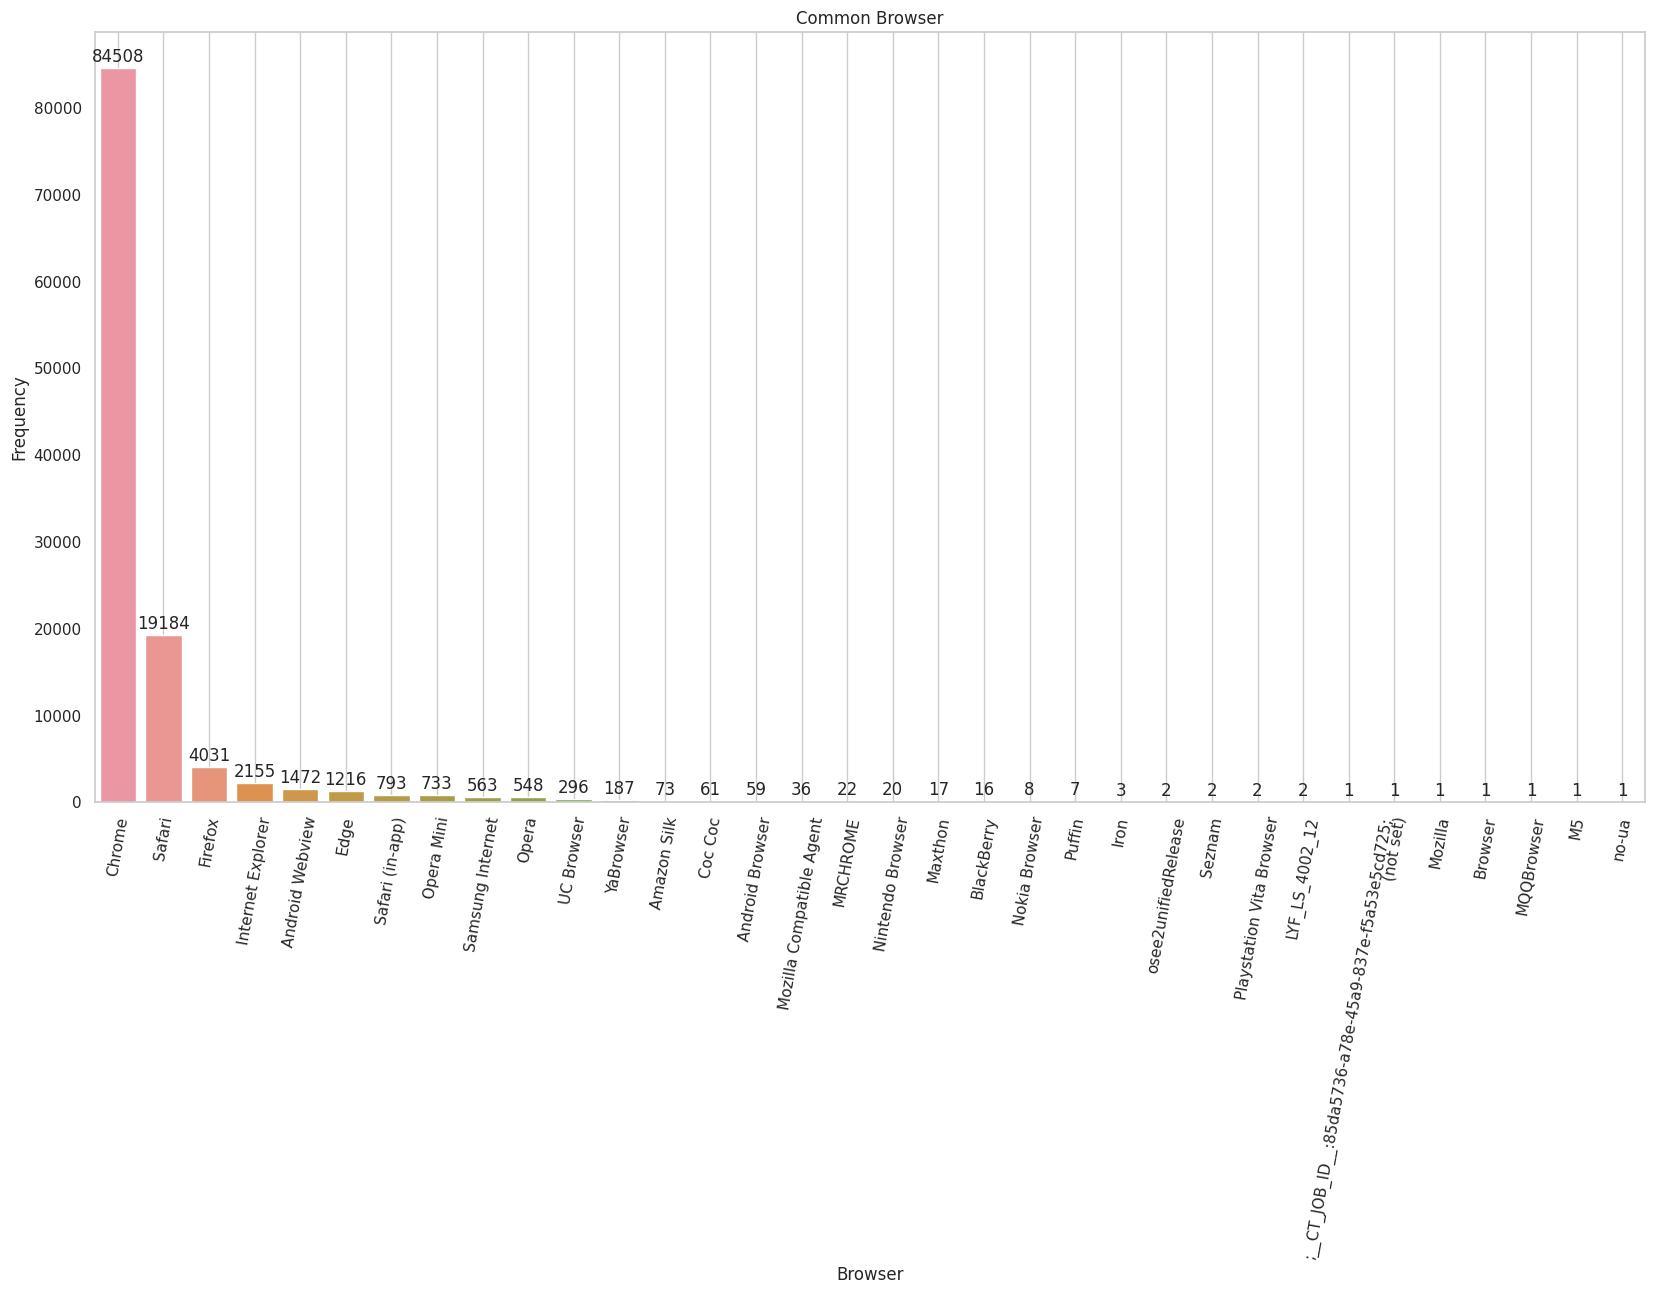

In [17]:
# Browser used by users 
commonBrowser = dfTrain['browser'].value_counts()


plt.figure(figsize=(20,10))
cbbp = sns.barplot(x=commonBrowser.index , y=commonBrowser.values)   # cbbp = CommonBrowser BarPlot
for container in cbbp.containers:
    plt.bar_label(container,label='edge' , padding=2)
plt.grid()
plt.xlabel('Browser')
plt.ylabel('Frequency')
plt.xticks(rotation=80)
plt.title('Common Browser')
plt.show()

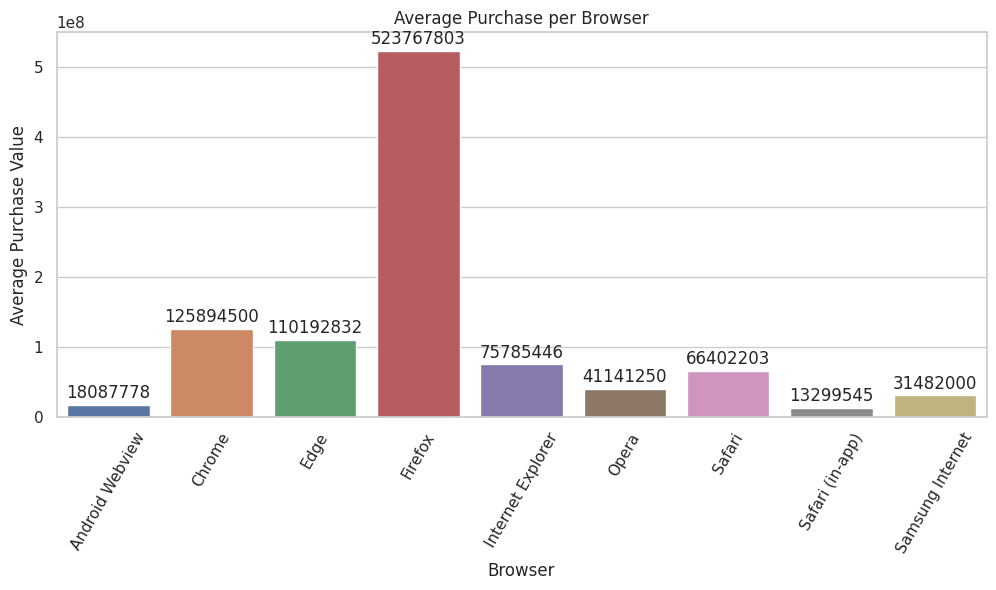

In [18]:
# Average Purchase Value by each Browser 
avgPurchasebyBrowser = dfTrain[dfTrain['purchaseValue'] > 0].groupby('browser')['purchaseValue'].mean()

plt.figure(figsize=(12,5))
apbbp = sns.barplot(x=avgPurchasebyBrowser.index, y=avgPurchasebyBrowser.values)
# apbbp = Average Purchase By Browser Bar Plot 
for container in apbbp.containers:
    plt.bar_label(container,label='edge' , padding=2 ,fmt='%.0f')
plt.xlabel('Browser')
plt.ylabel('Average Purchase Value')
plt.xticks(rotation=60)
plt.title('Average Purchase per Browser')
plt.show()


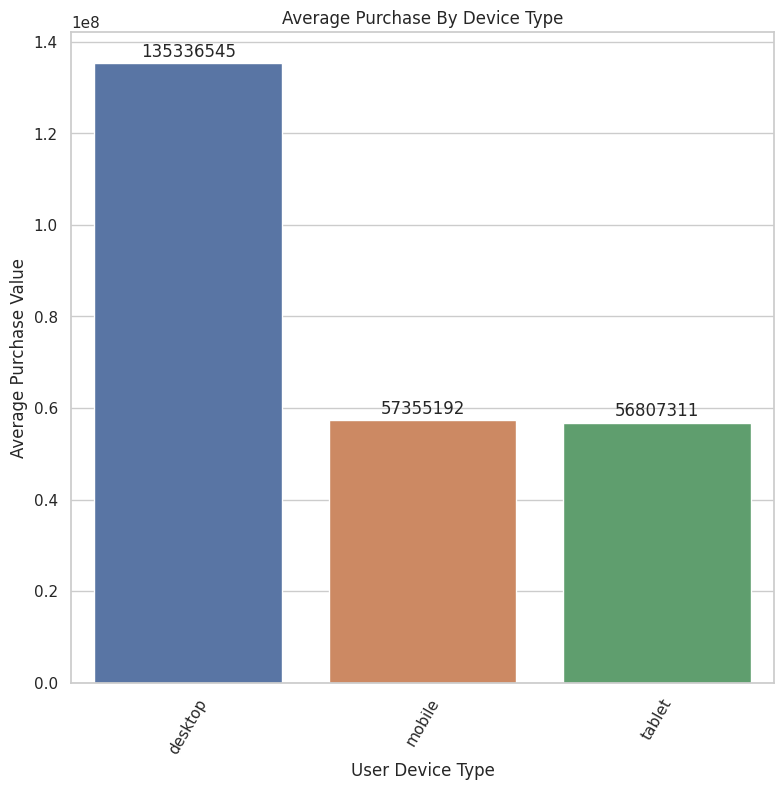

In [19]:
avgPurchaseDeviceType  = dfTrain[dfTrain['purchaseValue'] > 0].groupby('deviceType')['purchaseValue'].mean()

plt.figure(figsize=(8,8))
apdTbp = sns.barplot(x=avgPurchaseDeviceType.index, y=avgPurchaseDeviceType.values)
# apUmbp = Average Purchase By Device Type Bar Plot 
for container in apdTbp.containers:
    plt.bar_label(container,label='edge', padding=2 ,fmt='%.0f')
plt.xlabel('User Device Type')
plt.ylabel('Average Purchase Value')
plt.xticks(rotation=60)
plt.tight_layout()
plt.title('Average Purchase By Device Type')
plt.show()

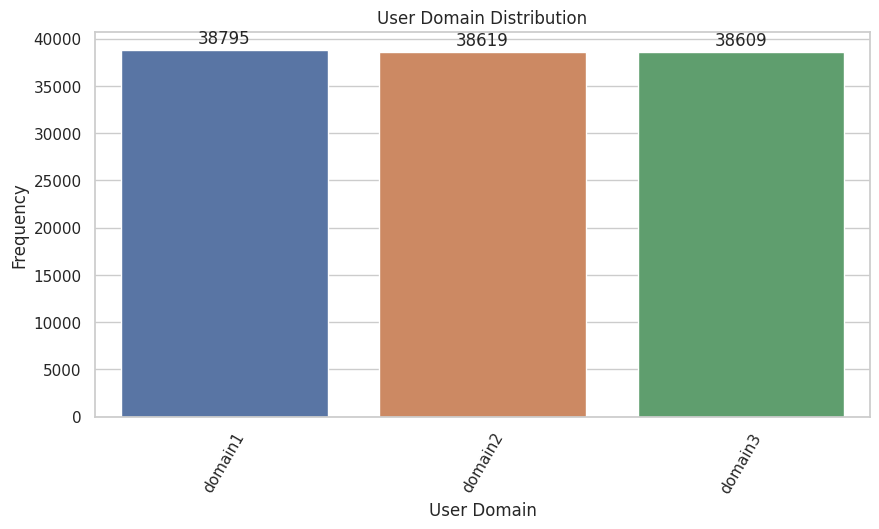

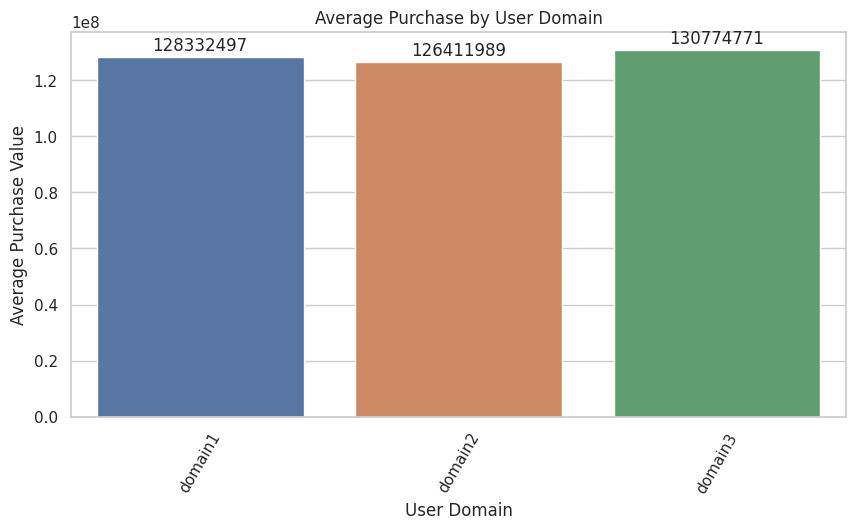

In [20]:
userDomain = dfTrain['geoNetwork.networkDomain'].value_counts() 
avgPurchasebyDomain= dfTrain[dfTrain['purchaseValue'] != 0].groupby(dfTrain['geoNetwork.networkDomain'])['purchaseValue'].mean()

# Distribution of User Domain in dataset
plt.figure(figsize=(10,5))
uDbp = sns.barplot(x=userDomain.index , y=userDomain.values)   # uDbp = User Medium Bar Plot 
for container in uDbp.containers:
    plt.bar_label(container,label='edge' , padding=2)
plt.xlabel('User Domain')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.title('User Domain Distribution')
plt.show()

# Plot of average purchase by each domains 
plt.figure(figsize=(10,5))
apuDbp = sns.barplot(x=avgPurchasebyDomain.index , y=avgPurchasebyDomain.values)   # apuDbp = average purchase by user domain Bar Plot 
for container in apuDbp.containers:
    plt.bar_label(container,label='edge' , padding=2 , fmt='%.0f')
plt.xlabel('User Domain')
plt.ylabel('Average Purchase Value')
plt.xticks(rotation=60)
plt.title('Average Purchase by User Domain')
plt.show()

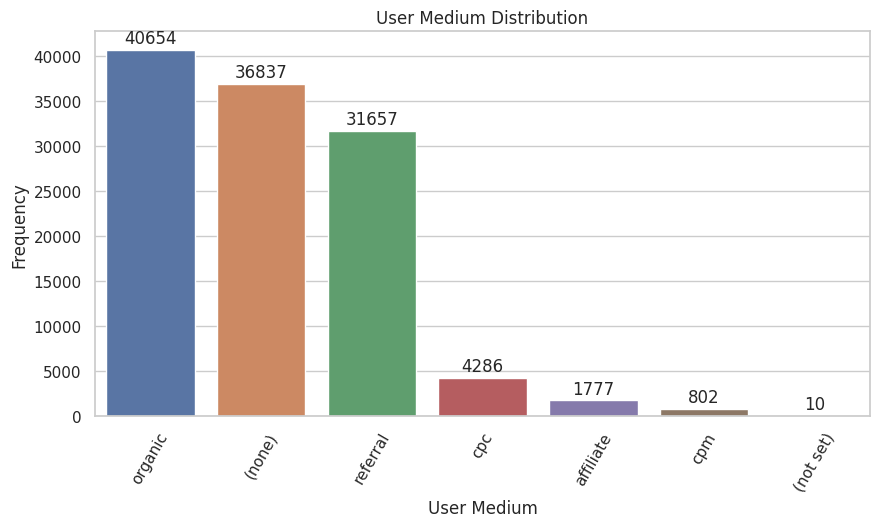

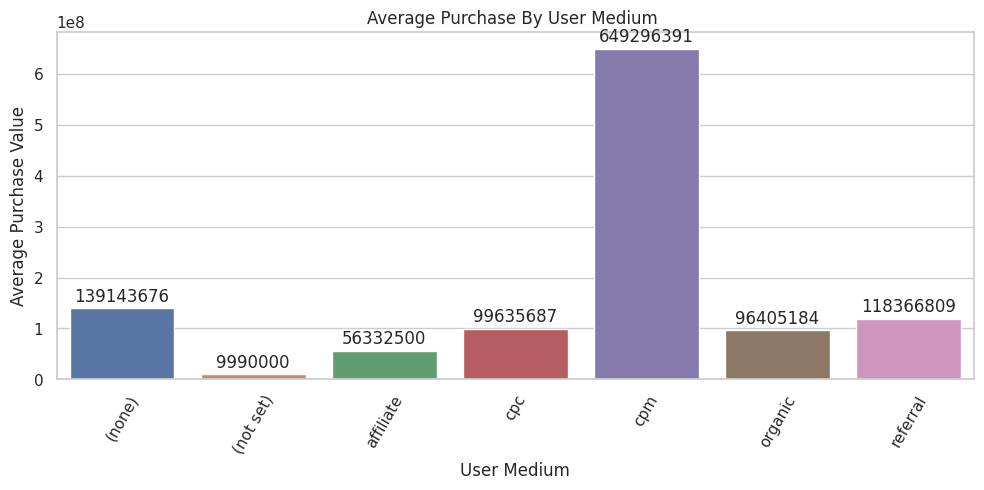

In [21]:
userMedium = dfTrain['trafficSource.medium'].value_counts()
avgPurchaseUserMedium  = dfTrain[dfTrain['purchaseValue'] > 0].groupby('trafficSource.medium')['purchaseValue'].mean()


# Plot to visualize how user comes to a page
plt.figure(figsize=(10,5))
uMbp = sns.barplot(x=userMedium.index , y=userMedium.values)   # uMbp = User Medium Bar Plot 
for container in uMbp.containers:
    plt.bar_label(container,label='edge' , padding=2)
plt.xlabel('User Medium')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.title('User Medium Distribution')
plt.show()


# plot to visualize the average purchase of user across different traffic mediums 
plt.figure(figsize=(10,5))
apUmbp = sns.barplot(x=avgPurchaseUserMedium.index, y=avgPurchaseUserMedium.values)   # apUmbp = Average Purchase By User Medium Bar Plot 
for container in apUmbp.containers:
    plt.bar_label(container,label='edge', padding=2 ,fmt='%.0f')
plt.xlabel('User Medium')
plt.ylabel('Average Purchase Value')
plt.xticks(rotation=60)
plt.tight_layout()
plt.title('Average Purchase By User Medium ')
plt.show()


<h4>Observation</h4>

* The dataset includes information on the user's browser and device category (desktop, mobile, tablet).
* `Chrome` is the most commonly used browser, followed by `Safari and Firefox`.
* Despite Chrome being most commonly used browser, `Average Transaction Value is very high on Firefox`.
* This indicate a few very high-value purchases by Firefox users.
* Chrome and Edge are the next highest contributors.
* Most user(s) prefer `Desktop` to make any purchase.
* Mobiles & Tablets are minimally used by the users.

* Users are almost equally scattered across all domains i.e. domain1, domain2 ,domain3.
* Average Purchase Value is also approximately equal across all domains.
* This indicates `geoNetwork.networkDomain` might have an equal imapact on  the target variable.

* Users arrive from various traffic sources, including organic search, direct visit, referral, and cpm.
* Traffic from `cpm` and `referrals` shows a higher likelihood of purchase.
* Organic and referral sources have broader reach but mixed effectiveness in making purchase.
* These observations suggest that traffic quality varies by source, and source type should be included as a categorical feature in modeling.

<hr><hr>

<h4>User Behaviour Insights</h4>


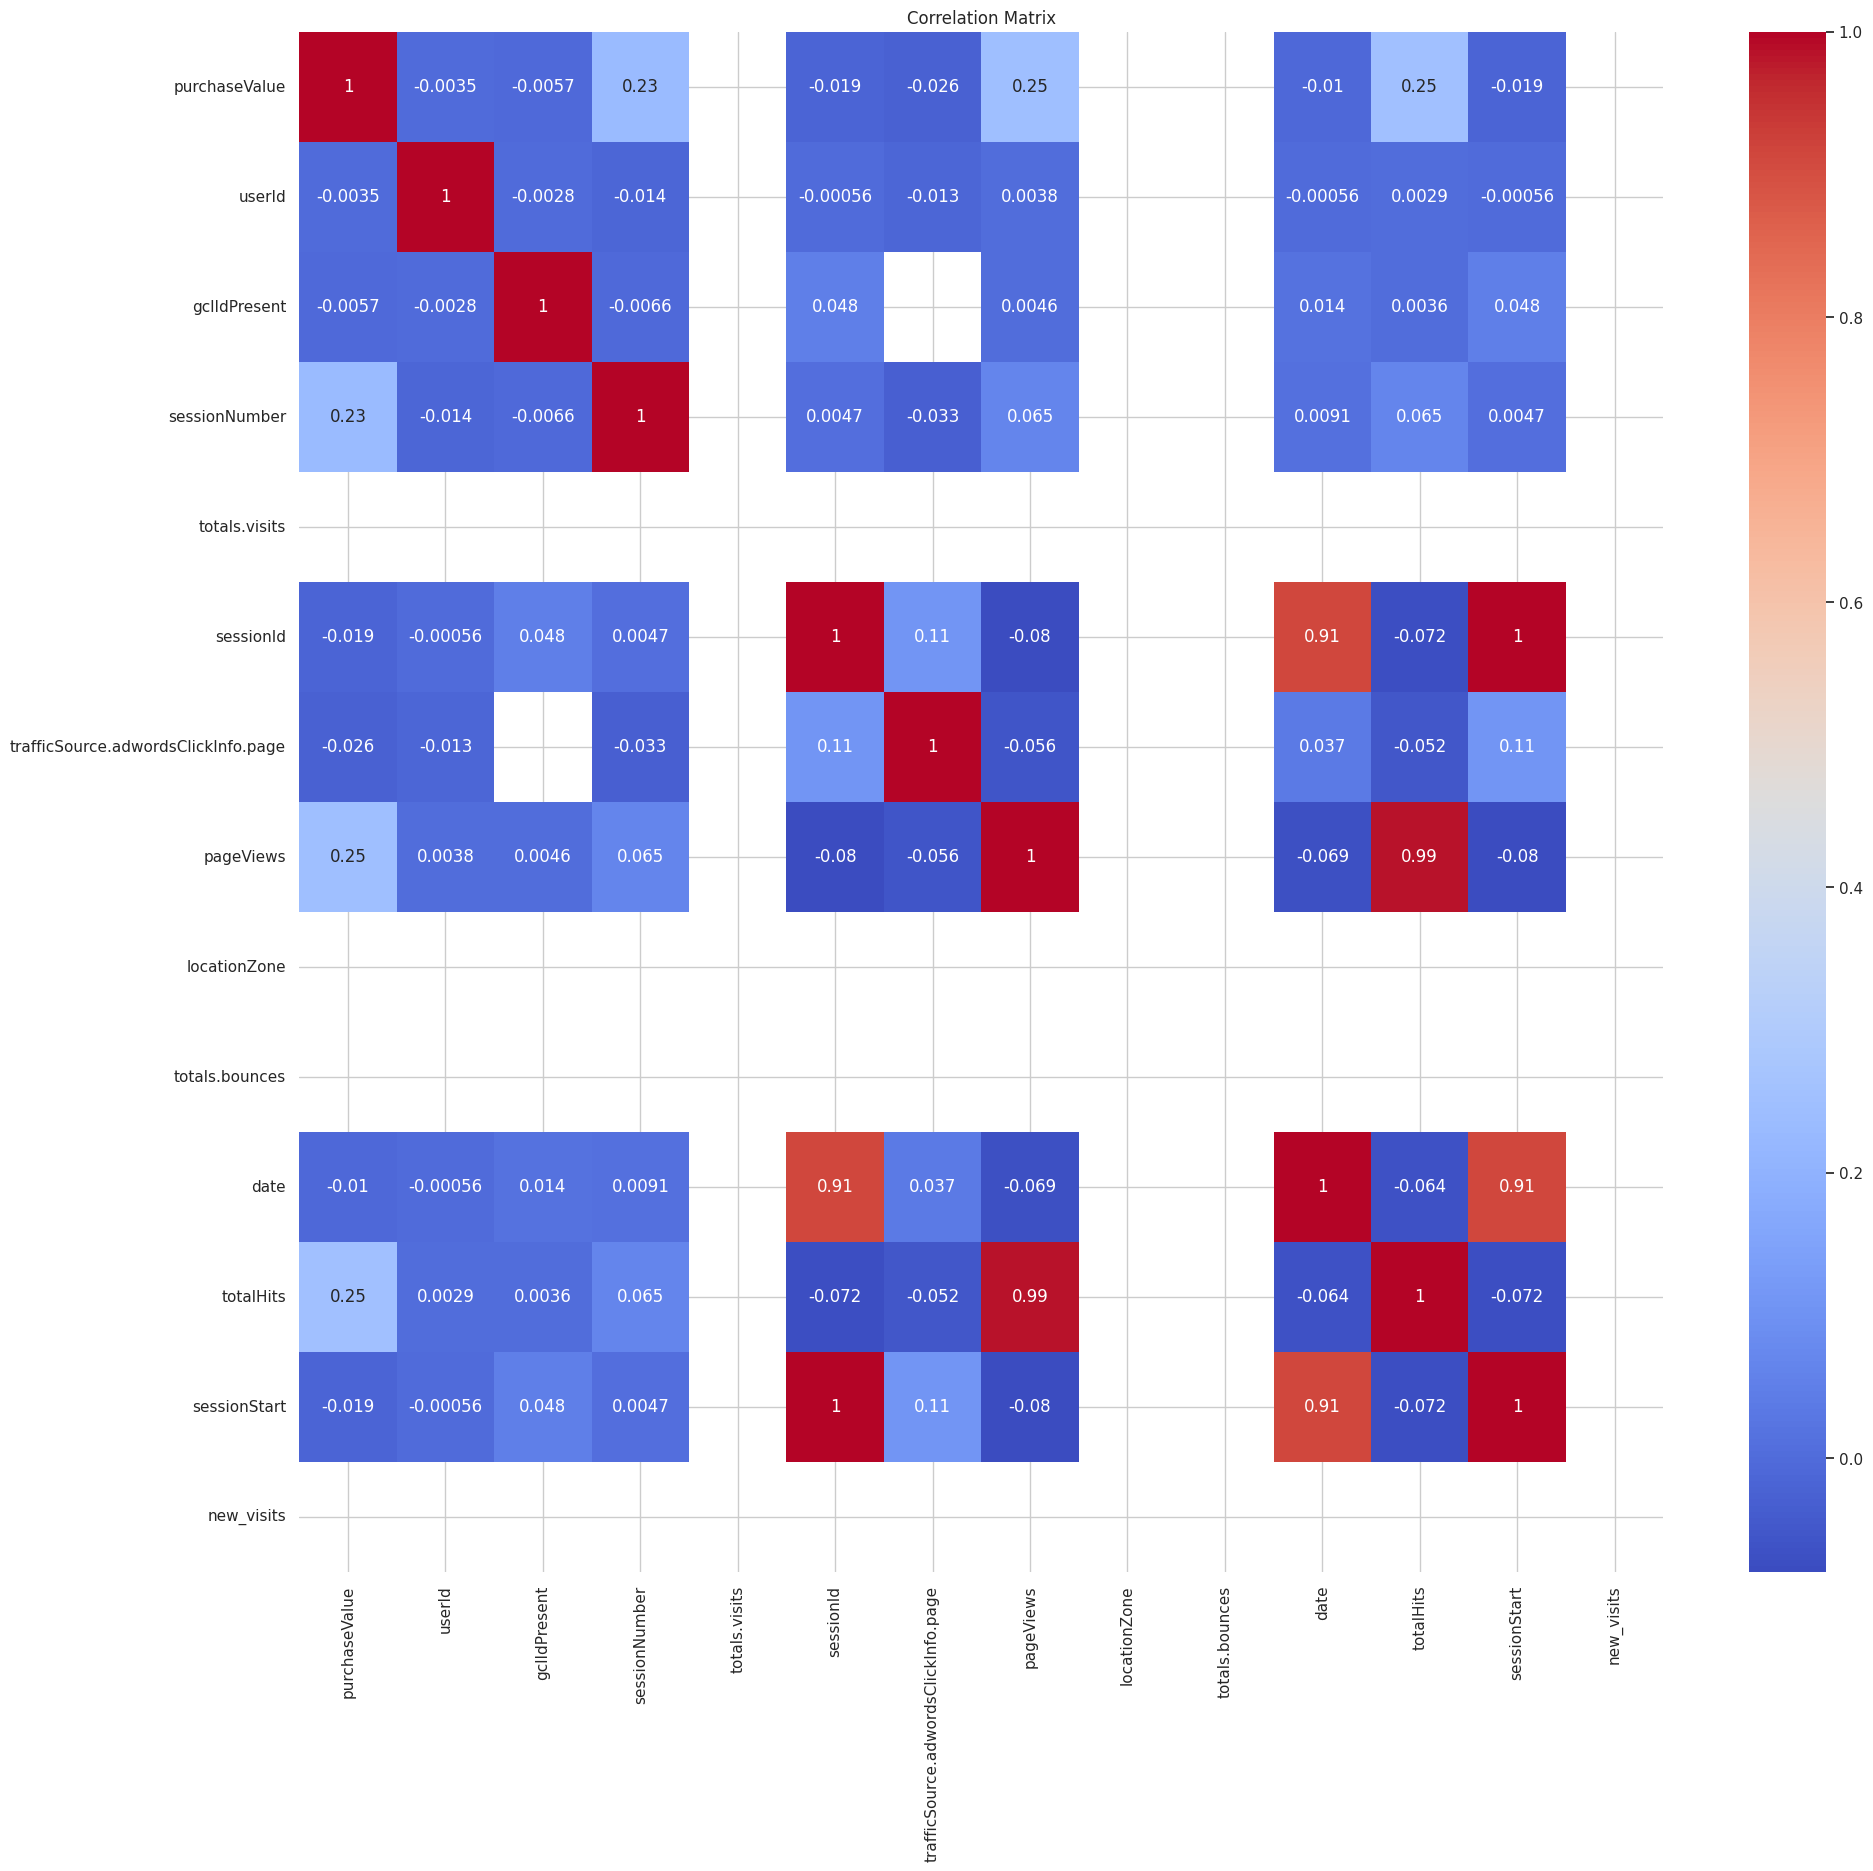

In [22]:
# Correlation Matrix
correlationMatrix = dfTrain[numericColumns].corr()

# Plotted the correlation heatmap to see the correlation among numerical datas.
plt.figure(figsize=(22,20))
sns.heatmap(correlationMatrix,annot=True , cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


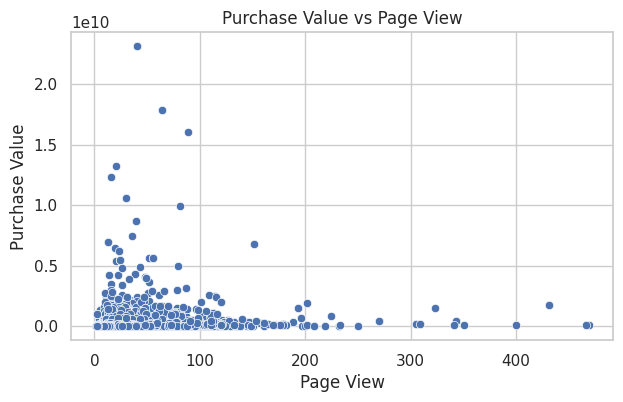

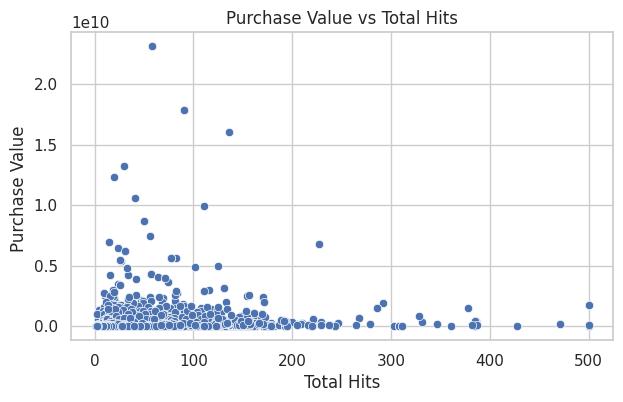

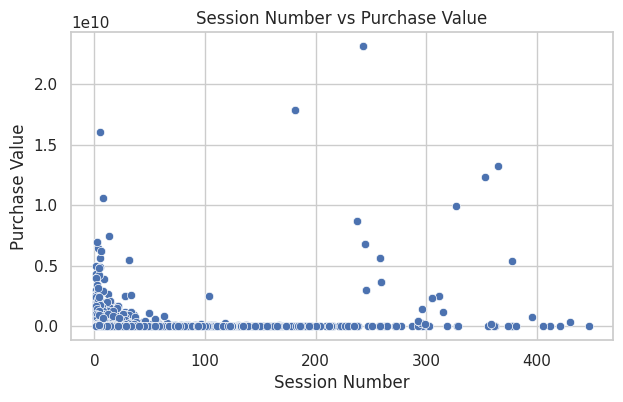

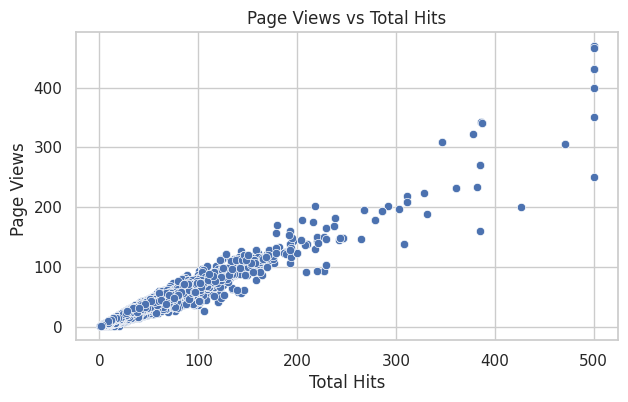

In [23]:
# Based on correlation coefficient different Plots 

# Purchase Value vs Page View Scatter Plot 
plt.figure(figsize=(7, 4))
sns.scatterplot(x=dfTrain['pageViews'],y=dfTrain['purchaseValue'] )
plt.ylabel('Purchase Value')
plt.xlabel('Page View')
plt.title('Purchase Value vs Page View')
plt.show()

# Purchase Value vs Total Hits Scatter Plot 
plt.figure(figsize=(7, 4))
sns.scatterplot(y=dfTrain['purchaseValue'],x=dfTrain['totalHits'] )
plt.ylabel('Purchase Value ')
plt.xlabel('Total Hits')
plt.title('Purchase Value vs Total Hits')
plt.show()

# Session Number vs Purchase Value Scatter Plot 
plt.figure(figsize=(7, 4))
sns.scatterplot(x=dfTrain['sessionNumber'],y=dfTrain['purchaseValue'] )
plt.ylabel('Purchase Value')
plt.xlabel('Session Number')
plt.title('Session Number vs Purchase Value')
plt.show()

# Page View vs Total Hits Scatter Plot 
plt.figure(figsize=(7, 4))
sns.scatterplot(y=dfTrain['pageViews'],x=dfTrain['totalHits'] )
plt.ylabel('Page Views ')
plt.xlabel('Total Hits')
plt.title('Page Views vs Total Hits')
plt.show()


<h4>Observations</h4>

* Scatter plots between purchaseValue and variables like pageViews, totalHits, and sessionNumber,which shows positive correlation.
* Users who spend more time on the site, view more pages, and return more frequently (higher sessionNumber) are more likely to make a purchase.
* This indicates that engaged users are most likely to make a purchase 

<hr><hr>

<hr><h1>5. <u>Data Cleaning & Preprocessing  </u></h1>
<hr>

In [24]:
# Making a copy of DataSet
X = dfTrain.copy()

print("Successfully made copy of Original DataSet")

Successfully made copy of Original DataSet


<h2> 5.1 Duplicates </h2>

<hr>


In [25]:
duplicateRows = X.duplicated().sum()
print()
print(f'{duplicateRows} duplicates present.')
X = X.drop_duplicates()
print(f'{duplicateRows} duplicates deleted successfully!')


236 duplicates present.
236 duplicates deleted successfully!


<h4>Observation </h4>

* The training data consists of 236 duplicate rows.
* Duplicate data should be removed as they are creating noise.
* Shape of training data after droping duplicates (115787 , 52).

<h2> 5.2 Feature Engineering </h2>
<hr>

```
New features were created to capture meaningful user behaviors and improve model performance.
```



In [26]:
userAvgPurchase = X[X['purchaseValue'] > 0].groupby('userId')['purchaseValue'].mean()
X['userAvgPurchase'] = X['userId'].map(userAvgPurchase)
X['userAvgPurchase'] = X['userAvgPurchase'].fillna(X['userAvgPurchase'].median())

dfTest['userAvgPurchase'] = dfTest['userId'].map(userAvgPurchase)
dfTest['userAvgPurchase'] = dfTest['userAvgPurchase'].fillna(X['userAvgPurchase'].median())

browserPurchaseRate = X[X['purchaseValue'] > 0].groupby('browser').size() / X.groupby('browser').size()
X['browserPurchaseRate'] = X['browser'].map(browserPurchaseRate).fillna(0)
dfTest['browserPurchaseRate'] = dfTest['browser'].map(browserPurchaseRate).fillna(0)


print("User Average by Purchase Feature made successfully!")

def featureEngineering(df):

    df['logTpageViews'] = np.log1p(df['pageViews'])
    df['logTtotalHits'] = np.log1p(df['totalHits'])
    df['logTsessionNumber'] = np.log1p(df['sessionNumber'])
    
    # Extracted hour, day and month etc from Session Start feature
    df['hour'] = pd.to_datetime(df['sessionStart'],unit='s').dt.hour
    df['dayofweek'] = pd.to_datetime(df['sessionStart'],unit='s').dt.weekday
    df['month'] = pd.to_datetime(df['sessionStart'],unit='s').dt.month
    df['isPeakHour'] = df['hour'].between(9,17).astype(int)

    # Made these feature(s) based on correlation of these
    df['totalHitsPageviewRatio'] = df['logTtotalHits'] / (df['logTpageViews']).replace(0,1)
    df['userSessions'] = df.groupby('sessionId')['logTsessionNumber'].transform('count')
    df['sessionNumberCrossuserSessions'] =  df['userSessions'] * df['logTsessionNumber'] 
    df['pageViewsCrossTotalHits'] = df['logTpageViews'] * df['logTtotalHits']
    df['sessionNumberCrossTotalHits'] = df['logTsessionNumber'] * df['logTtotalHits']
    df['userActiveSession'] = (df['logTpageViews'] + df['logTtotalHits']) / (df['logTsessionNumber']+1)  
    df['userInteractionIntensity'] = (df['pageViewsCrossTotalHits']) / ((df['logTsessionNumber'])+1e-4)
    df['hitsPerPageviewCrossactiveSession'] = df['totalHitsPageviewRatio'] * df['userActiveSession']
    df['isReturningUser'] = ((df['logTpageViews'].replace(0,1)) > 1).astype(int)
    df['userRecency'] = (df['pageViews']*2 + df['totalHits']*2) / (df['sessionNumber'] + 1e-4)
   

    return df 


X = featureEngineering(X)
dfTest = featureEngineering(dfTest)

print('Feature Engineering applied successfully.')

User Average by Purchase Feature made successfully!
Feature Engineering applied successfully.


<h4>Observation</h4>

* Extracted hour, dayOfWeek, and month from the session timestamp to capture time-based patterns in purchasing behavior.

* Heavily Skewed features such as pageViews, totalHits , sessionNumber are log transformed to reduce skewness.

* Created features like:

    * ```userActiveSession = (pageViews + totalHits) / (sessionNumber+1)```

    * ```userInteractionIntensity = (pageViews × totalHits) / (sessionNumber+1e-4)```

* These features reflect user engagement and intensity per session.

* Calculated user-level features like `userAvgPurchase`, giving the average purchase per user.

In [27]:
def dropColumns(df):
    limit = 0.7
    nullFraction = df.isnull().mean()
    nullCol = nullFraction[nullFraction > limit].index.tolist()
    RepeatedCol = ['totalHits' , 'pageViews' ,'sessionNumber']
    extraCol = ['userId','geoNetwork.subContinent','device.isMobile','sessionId'
                     ,'date' ,'sessionStart' , 'locationCountry' ,'os','geoCluster','gclIdPresent',
                     'geoNetwork.networkDomain','trafficSource'  , 'userChannel',]
    
    for col in df.columns:
        if df[col].nunique(dropna=False) == 1:
            RepeatedCol.append(col)
        else:
            count = 0
            for val in df[col]:
                if val == "not available in demo dataset" or pd.isna(val) or val == "(not set)":
                    count += 1
                if count > (0.1*df.shape[0]):
                    RepeatedCol.append(col)
    
    colToDrop = (nullCol + RepeatedCol + extraCol) 
    
    df_cleaned = df.drop(columns=colToDrop ,axis=1)
    return df_cleaned

X = dropColumns(X)
dfTest = dropColumns(dfTest)

print("Drop Column executed successfully.")

Drop Column executed successfully.


<h4>Observations</h4>

```
The function dropColumns() is made to remove low-quality, redundant, and irrelevant features to improve data quality, reduce noise, and enhance model performance.

```

* Columns with more than 70% missing values are automatically dropped.
  
* These features don't have sufficient information and may introduce bias or instability during training.

  
* Columns with single unique values are dropped.

  
* These features have no variance and are not helpful for prediction.

  
* Features with over 10% of entries as "not available in demo dataset", "(not set)", or NaN are flagged.

  
* A predefined list of columns was removed, including:
    * `userId, sessionId, date, sessionStart` – These are unique identifiers or timestamps, not helpful in generalization.
      
    * `geoCluster, locationCountry, os, trafficSource` – Often very high in cardinality.
    * `device.isMobile, gclIdPresent, geoNetwork.networkDomain, userChannel` – Often sparse, redundant, and contains inconsistent values.

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115787 entries, 0 to 116022
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   purchaseValue                      115787 non-null  float64
 1   browser                            115787 non-null  object 
 2   trafficSource.medium               115787 non-null  object 
 3   deviceType                         115787 non-null  object 
 4   geoNetwork.continent               115787 non-null  object 
 5   userAvgPurchase                    115787 non-null  float64
 6   browserPurchaseRate                115787 non-null  float64
 7   logTpageViews                      115779 non-null  float64
 8   logTtotalHits                      115787 non-null  float64
 9   logTsessionNumber                  115787 non-null  float64
 10  hour                               115787 non-null  int32  
 11  dayofweek                          115787 no

In [29]:
# Numerical Features 
correlations = X.select_dtypes(include='number').corr()['purchaseValue'].drop('purchaseValue').sort_values(ascending=False)
numFeatures = correlations.index.to_list()
impFeature = correlations[correlations.values > 0.0].index.to_list()
nonImpFeatures = list(set(numFeatures) - set(impFeature))
print(f'Important Features : {impFeature}')

# Categorical Features 
catFeatures = X.select_dtypes(include='object').columns.to_list() 
print(f'Categorical Features : {catFeatures}')

Important Features : ['userAvgPurchase', 'sessionNumberCrossTotalHits', 'sessionNumberCrossuserSessions', 'pageViewsCrossTotalHits', 'logTtotalHits', 'logTpageViews', 'logTsessionNumber', 'userSessions', 'userInteractionIntensity', 'hitsPerPageviewCrossactiveSession', 'userActiveSession', 'userRecency', 'isReturningUser', 'totalHitsPageviewRatio', 'browserPurchaseRate', 'hour']
Categorical Features : ['browser', 'trafficSource.medium', 'deviceType', 'geoNetwork.continent']


<h2> 5.3 Train Test Split </h2>
<hr>

<h4>Observations</h4>

* The column `purchaseValue` is extracted as the target variable Y.
* The same column(purchaseValue) is removed from the input feature set X.
* The dataset is split using an `80/20` ratio, where:
    * `X_train, y_train` are used to train the models.
    * `X_test , y_test` are used to evaluate the training performance.
* The `random_state=42` ensures reproducibility of results across runs.

In [30]:
Y = X['purchaseValue'] #Target Column
X = X.drop(columns=['purchaseValue'] , axis=1)

# Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

print("Train Test Split executed Successfully.")

Train Test Split executed Successfully.


<h2> 5.4 Data Preprocessing </h2>
<hr>

```
Preprocessing ensured that features were cleaned, standardized, and encoded before feeding into machine learning models.
```



In [31]:
# Numerical Features Pipeline 
impNumPipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
        ('scaler1', StandardScaler())
    ])

nonImpPipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler2', StandardScaler())
    ])

# Categorical Features Pipeline 
catPipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('oneHot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

# Preprocessing 
preprocessor = ColumnTransformer([
    ('impNum' , impNumPipe , impFeature),
    ('nonImp' , nonImpPipe , nonImpFeatures),
    ('cat' , catPipe , catFeatures)
], remainder='passthrough')

print("Successfully made Numerical Feature Pipeline.")
print("Successfully made Categorical Feature Pipeline.")
print("Preprocessed Numerical and Categorical Data.")

Successfully made Numerical Feature Pipeline.
Successfully made Categorical Feature Pipeline.
Preprocessed Numerical and Categorical Data.


<h4>Observations</h4>

* Numerical Features:

    * Imputed with median values.

    * Feature(s) with correlation greater than zero were transformed using polynomial features to capture non-linear relationships and scaled .

* Categorical Features:

    * Imputed with most frequent values.

    * Transformed using One-Hot Encoding.

* ColumnTransformer was used to apply different transformations to different types of columns in a clean, modular way.

<hr>
<h1>
    <u>
        6. Model Building
    </u>
</h1>
<hr>

<h3> 6.0 Dummy Regression Model </h3>
<hr>

In [32]:
dummyModel = Pipeline([
    ('preprocessor',preprocessor),
    ('dReg' , DummyRegressor())
])

dummyModel.fit(X_train,y_train)
y_predDummy=dummyModel.predict(X_test)

print('Successfully Applied Dummy Regressor')
print(f'R2 Score (Dummy Regressor): {r2_score(y_test,y_predDummy):.5f}')

Successfully Applied Dummy Regressor
R2 Score (Dummy Regressor): -0.00006


<h2> 6.1 Linear Regression Model</h2> 
<hr>

<h4>Observation</h4>

* A basic regression model to assume a linear relationship between features and target.
* The R² score was highly negative, indicating:
    * The relationship is likely non-linear.
    * The feature scaling and transformation are not sufficient for this model.

In [33]:
linearModel = Pipeline([
    ('preprocessor', preprocessor),
    ('lReg', LinearRegression())
])

linearModel.fit(X_train, y_train)
y_predLinear = linearModel.predict(X_test)

print("Linear Regression Model executed.")
print(f'R2 Score (Linear Regression): {r2_score(y_test, y_predLinear):.5f}')

Linear Regression Model executed.
R2 Score (Linear Regression): -61926850.05795


<h2> 6.2 Ridge Regression Model </h2>
<hr>

<h4>Observations</h4>

* A regularized linear model that adds L2 penalty to reduce overfitting and handle multicollinearity.
* Shows improvement in R² over Linear Regression, but still limited in capturing complex patterns in the data.
* Highlights that simple linear models are insufficient for this task.

In [34]:
ridgeModel = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0, random_state=42))
])

ridgeModel.fit(X_train, y_train)
y_predRidge = ridgeModel.predict(X_test)

print("Applied Ridge Regression Model!")
print("R2 Score:", round(r2_score(y_test, y_predRidge),5))

Applied Ridge Regression Model!
R2 Score: 0.6304


<h2>6.3 XGBoost Regressor Model </h2>
<hr>

<h4>Observations</h4>

* A powerful tree-based ensemble method designed for non-linear and sparse data.
* Custom hyperparameters like `max_depth, n_estimators, and learning_rate` were tuned for performance.
* XGBoost significantly outperforms all other models and is best suited for this prediction problem.

In [35]:
xgbModel = Pipeline([
        ('preprocessor' , preprocessor),
        ('regressor' , xg.XGBRegressor(
            n_estimators=789,
            random_state=42,
            n_jobs=-1,
            max_depth=7, 
            learning_rate=0.1
        ))
    ])

    
xgbModel.fit(X_train, y_train)
y_predXgb = xgbModel.predict(X_test)

print("Applied XGBoost Model!")
print("R2 Score (XGBRegressor):", round(r2_score(y_test, y_predXgb),5))

Applied XGBoost Model!
R2 Score (XGBRegressor): 0.77889


```python
HyperTuned Parameters 

Best R² Score from CV:0.78896
Best Parameters:{
    'xgb__n_estimators':389
    'xgb__max_depth':6
    'xgb__learning_rate':0.1
}
R² Score on Test Set:0.87373


<h4>HyperParameter Tuning</h4>
<hr>

```python

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', xg.XGBRegressor(
        random_state=42,
        n_jobs=-1
    ))
])


param_dist = {
    'xgb__n_estimators': randint(200, 1000),
    'xgb__max_depth': randint(2, 10),
    'xgb__learning_rate': [0.03,0.05,0.07,0.09,0.1,0.3]
}


search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=-1
)
search.fit(X_train, y_train)

print("Best R² Score from CV:", search.best_score_)
print("Best Parameters:", search.best_params_)

best_model = search.best_estimator_
y_pred_test = best_model.predict(X_test)
print("R² Score on Test Set:", r2_score(y_test, y_pred_test))



<h2>6.4 Model Comparision</h2>
<hr>

In [36]:
models = {
    "Dummy Regressor": dummyModel,
    "Linear Regression": linearModel,
    "Ridge Regression": ridgeModel,
    "XGBoost Regressor": xgbModel
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    results.append({
        "Model": name,
        "R2 Score": round(r2, 5)
    })

results_df = pd.DataFrame(results).sort_values(by="R2 Score", ascending=False)
print("Model Performance Comparison:")
print(results_df)

Model Performance Comparison:
               Model      R2 Score
3  XGBoost Regressor  7.788900e-01
2   Ridge Regression  6.304000e-01
0    Dummy Regressor -6.000000e-05
1  Linear Regression -6.192685e+07


<hr>
<h1><u>
    7. Evaluation
</u></h1><hr>

<h4>Observation</h4>


```
After training and evaluating the final model (XGBoost Regressor), predictions were made on the test dataset to generate the final output for submission.
```
* The model xgbModel was used to make predictions on the preprocessed test dataset dfTest.
* A DataFrame named submissions was created with two columns:

    * `id`: A unique index for each prediction.

    * `purchaseValue`: The predicted values from the test set.



In [37]:
test_pred = xgbModel.predict(dfTest)

submissions = pd.DataFrame({"id": range(test_pred.shape[0]), "purchaseValue": test_pred})
submissions.to_csv('submission.csv', index=False)

print("Submission File made successfully!")

Submission File made successfully!


<hr>
<h1><u>8. Milestones </u> </h1>
<hr>

<h2>8.1 MileStone 1</h2>
<hr>

In [38]:
continentBytotalHits = dfTrain.groupby(dfTrain['geoNetwork.continent'])['totalHits'].mean().sort_values(ascending=False)
continentBytotalHits # Q1

geoNetwork.continent
Americas     15.377978
(not set)     5.147059
Oceania       4.678705
Asia          3.513939
Europe        3.186705
Africa        2.812822
Name: totalHits, dtype: float64

In [39]:
dfTrainCopy = dfTrain[(dfTrain['totals.bounces'].isna())] # Making a dataset where total bounces == NaN.
corrQ1 = dfTrainCopy['pageViews'].corr(dfTrainCopy['purchaseValue'])
print(f'Correlation between the number of pageviews and the purchase value, considering only users who did not bounce is: {corrQ1}')

Correlation between the number of pageviews and the purchase value, considering only users who did not bounce is: 0.22547226150716898


In [40]:
commonMedium = dfTrain[dfTrain['purchaseValue'] != 0 ]['trafficSource.medium'].value_counts()
print(f'The most common medium is: {commonMedium.idxmax()}')

The most common medium is: (none)


In [41]:
commonBrowser = dfTrain[dfTrain['purchaseValue'] != 0]['browser'].value_counts()
commonOs = dfTrain[dfTrain['purchaseValue'] != 0]['os'].value_counts()
print(f'The pair of most common browser and os are ({commonBrowser.idxmax()} , {commonOs.idxmax()}) respectively.')

The pair of most common browser and os are (Chrome , Macintosh) respectively.


In [42]:
numerator = dfTrain[dfTrain['purchaseValue'] != 0]['totalHits'].mean()
denominator = dfTrain[dfTrain['purchaseValue'] == 0]['totalHits'].mean()
ratio = numerator/denominator
print(f'The ratio of average number of hits for sessions that resulted in a purchase compared to those that did not is {ratio}')

The ratio of average number of hits for sessions that resulted in a purchase compared to those that did not is 8.620424953311248


<h4>What is the proportion of 'organic' sessions in comparison to all other types of sessions from each traffic source medium?</h4>

<hr>


In [43]:
organicRatio = dfTrain[(dfTrain['trafficSource.medium']=='organic')]['trafficSource.medium'].count()/dfTrain['trafficSource.medium'].count()
print(f'The proportion of organic sessions in comparison to all other types of sessions from each traffic source medium is {organicRatio}.')

The proportion of organic sessions in comparison to all other types of sessions from each traffic source medium is 0.3503960421640537.


<h4>Which referral path is most common for sessions that resulted in a purchase?</h4>

<hr>

In [44]:
commonReferal = dfTrain[dfTrain['purchaseValue'] != 0]['trafficSource.referralPath'].value_counts()
print(f'The most common referral path is: {commonReferal.idxmax()}')

The most common referral path is: /


<h4>Which operating system has the highest average purchase value?</h4>

<hr>

In [45]:
maxOsPurchase = dfTrain.groupby(dfTrain['os'])['purchaseValue'].mean().sort_values(ascending=False)
print(f'The operating system with the highest average purchase value is: {maxOsPurchase.idxmax()}')

The operating system with the highest average purchase value is: Chrome OS


<h4>What is the average number of sessions per user?</h4>

<hr>

In [46]:
avgNum = dfTrain['sessionNumber'].count()/(dfTrain['userId'].nunique())

print(f'The average number of session per user is {avgNum}.')

The average number of session per user is 1.1544691986984945.


<h4>How many unique users are there in the dataset?</h4>

<hr>

In [47]:
uniqueUsers = dfTrain['userId'].nunique()
print(f'There are {uniqueUsers} unique users in the dataset.')

There are 100499 unique users in the dataset.


<h2> 8.2 MileStone 2 </h2>
<hr>

<h4>When visualizing the distribution of totalHits across the dataset, which of the following would be most accurate?</h4>
<hr>

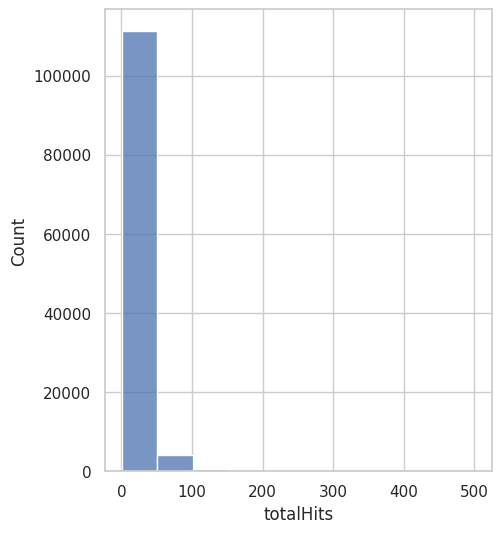

In [48]:
plt.figure(figsize=(5,6))
sns.histplot(dfTrain['totalHits'] , bins=10)
plt.show()

<h4>What is the correlation coefficient between pageViews and purchaseValue for mobile users only?</h4>
<hr>

In [49]:
mobileUser = dfTrain[dfTrain['device.isMobile'] == True ]
corre = mobileUser.select_dtypes(include='number').corr()
coef = corre['purchaseValue']['pageViews']
print(f'Correlation coefficient between pageViews and purchaseValue for mobile users only is : {coef:.2f}')

Correlation coefficient between pageViews and purchaseValue for mobile users only is : 0.37


<h4>A data scientist created a model to predict purchases using a 70-30 stratified train-validation split. If the validation set contains 20.68% of records with purchases and there were 23,985 purchase records in total, approximately how many purchase records were in the training set?</h4>
<hr>

In [50]:
totalRecords = 23985
print(f'There are {totalRecords*0.7:.0f} present in training set.')

There are 16790 present in training set.


<h4>When normalizing the purchase value column, what would be the approximate standard deviation of the normalized values?</h4>
<hr>

In [51]:
scaler = StandardScaler()
purchase_values = dfTrain['purchaseValue'].values.reshape(-1, 1)
transformed = scaler.fit_transform(purchase_values)
print('The standard deviation of normalized values is :',transformed.std())

The standard deviation of normalized values is : 1.0


<h4>If we build a linear regression model to predict purchase value using totalHits and pageViews as features, which coefficient would likely have a larger magnitude?</h4>
<hr>

In [52]:
df = dfTrain.copy()
df = df[['purchaseValue', 'totalHits', 'pageViews']].dropna()
X = df[['totalHits', 'pageViews']]
y = df['purchaseValue']

model = LinearRegression()
model.fit(X, y)

if abs(model.coef_[0]) > abs(model.coef_[1]):
    print("totalHits has a larger coefficient magnitude.")
else:
    print("pageViews has a larger coefficient magnitude.")

totalHits has a larger coefficient magnitude.


<h4>What percentage of the dataset has missing values in the totals.bounces column?</h4>
<hr>

In [53]:
dfTrain['totals.bounces'].value_counts()

totals.bounces
1.0    47148
Name: count, dtype: int64

<h2>8.3 MileStone 3</h2>
<hr>

<h4>Preprocessing Pipeline <br>
The preprocessing steps mentioned below are to be used for all the questions that are a part of this milestone.

Impute the categorical columns with the mode and the numerical columns with the mean.
Perform One Hot Encoding on all the categorical columns. Use a standard scaler to scale all the numerical columns, perform a train test split with a test size 0.2 and random state = 42.<h4>
<hr>

<h4>Model 1<br>
Fit a RandomForestRegressor model (random state = 42) on the training set and perform hyper parameter tuning using grid search with 3 folds and use scoring as r2, using the following values:

1. max_depth: [20, 30]
2. min_samples_split: [2, 5]
3. n_estimators: [50, 100]

What is the best value of n_estimators?</h4>
<hr>



```python
x = dfTrain.copy()

y = x['purchaseValue']
x = x.drop('purchaseValue' , axis = 1)

xTrain , xTest , yTrain , yTest = train_test_split(x,y,test_size=0.2,random_state=42)

numericColumns = x.select_dtypes(include='number').columns.to_list()
catColumns = x.select_dtypes(include='object').columns.to_list()

# Numerical Features Pipeline 
numericalPipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler1', StandardScaler())
    ]) 

# Categorical Features Pipeline 
categoricalPipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

# Preprocessing 
preprocessor2 = ColumnTransformer([
    ('num' , numericalPipe , numericColumns),
    ('cat' , categoricalPipe , catColumns)
], remainder='passthrough')

from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV

randomPipe = Pipeline([
    ('preprocessor',preprocessor2),
    ('randomRegressor' , RandomForestRegressor(random_state=42))
])

param_grid = {
    'randomRegressor__max_depth': [20, 30],
    'randomRegressor__min_samples_split': [2, 5],
    'randomRegressor__n_estimators': [50, 100]
}
grid = GridSearchCV(
    estimator=randomPipe,
    param_grid=param_grid,
    scoring='r2',
    cv=3    
)

# randomPipe.fit(xTrain,yTrain)
grid.fit(xTrain,yTrain)
print(grid.best_params_)
bestModel = grid.best_estimator_
y_predM3 = grid.predict(xTest)
print(f'R2 Score (Milestone 3)', r2_score(yTest, y_predM3))

<h4>Model 2</h4>
    <h4>
Fit an AdaBoostRegressor model (random state = 42) on the training set and perform hyper parameter tuning using grid search with 3 folds and use scoring as accuracy, using the following values :

    
1. n_estimators: [10, 20, 30]

2. learning_rate: [3, 9]

</h4>
<hr>

```python
from sklearn.ensemble import AdaBoostRegressor

paramGrid = {
    'adaBoost__n_estimators': [10, 20, 30],
    'adaBoost__learning_rate': [3, 9]
}

model2 = Pipeline([
    ('preprocessor',preprocessor2),
    ('adaBoost' , AdaBoostRegressor(random_state=42))
])

grid2 = GridSearchCV(
    estimator=model2,
    param_grid=paramGrid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)

grid2.fit(xTrain,yTrain)
bestParams = grid2.best_params_
bestModel = grid2.best_estimator_

print(f"Best parameters: {bestParams}")
print(f"Best R2 score: {r2_score(yTest,bestModel.predict(xTest)):.4f}")

<h2>8.4 MileStone 4</h2>
<hr>

<h4>Preprocessing steps:

Separate the training set into (X) and (Y) matrices

Use train_test_split with test_size=0.2 and random_state=39

Transform categorical variables by imputing with mode, then using OneHotEncoder. 

Transform numerical variables by imputing with mean then scale with Standard scalar

Round off the values to the nearest 3 digits
</h4> 

<h4>Fit the training data into MLPRegressor with hidden_layer=(5,3)</h4>
<hr>


```python
x = dfTrain.copy()

y = x['purchaseValue']
x = x.drop('purchaseValue' , axis = 1)

xTrain , xTest , yTrain , yTest = train_test_split(x,y,test_size=0.2,random_state=39)

numericColumns = x.select_dtypes(include='number').columns.to_list()
catColumns = x.select_dtypes(include='object').columns.to_list()

# Numerical Features Pipeline 
numericalPipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler1', StandardScaler())
    ]) 

# Categorical Features Pipeline 
categoricalPipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

# Preprocessing 
preprocessor2 = ColumnTransformer([
    ('num' , numericalPipe , numericColumns),
    ('cat' , categoricalPipe , catColumns)
], remainder='passthrough')


from sklearn.neural_network import MLPRegressor

mlpModel = Pipeline([
  ('preprocessor' , preprocessor2),
  ('milestone4' , MLPRegressor(
    hidden_layer_sizes=(5,3)
  ))
])

mlpModel.fit(xTrain,yTrain)
y_predMLP = mlpModel.predict(xTest)
print(f'R2 Score Test {r2_score(yTest,y_predMLP):.3f}')
print(f'R2 Score Training {mlpModel.score(xTrain,yTrain):.3f}')

```python
from sklearn.ensemble import VotingRegressor , GradientBoostingRegressor

votingModel1 = VotingRegressor(estimators=[
  ('linearReg' , LinearRegression()),
  ('gradientRegressor' , GradientBoostingRegressor(random_state=39))
])

pipe1 = Pipeline([
('preprocessor' , preprocessor2),
('reg' , votingModel1)
])

pipe1.fit(xTrain,yTrain)
print(f'R2 Score Training {pipe1.score(xTrain,yTrain):.3f}')
y_predV1 = pipe1.predict(xTest)
print(f'R2 Score Test {r2_score(yTest,y_predV1):.3f}')


votingModel2 = VotingRegressor(estimators=[
  ('RidgeReg' , Ridge(random_state=39)),
  ('gradientRegressor' , GradientBoostingRegressor(random_state=39))
])

pipe2 = Pipeline([
('preprocessor' , preprocessor2),
('reg' , votingModel2)
])
pipe2.fit(xTrain,yTrain)
print(f'R2 Score Training {pipe2.score(xTrain,yTrain):.3f}')
y_predV2 = pipe2.predict(xTest)
print(f'R2 Score Test {r2_score(yTest,y_predV2):.3f}')

<h2>8.5 MileStone 5 </h2>

<hr>

Part 1: Initial Data Cleaning

* Task: Clean and encode data using these rules:
    * Drop columns with >70% missing values
    * Drop high cardinality ID columns (userId, sessionId.)
    * Impute the NaN values of purchaseValue as 0.


```python

x = dfTrain.copy()

y = x['purchaseValue']
x = x.drop('purchaseValue' , axis = 1)

# Drop columns with >70% missing values
limit = 0.7
nullFraction = x.isnull().mean()
nullCol = nullFraction[nullFraction > limit].index.tolist()

x = x.drop(columns = nullCol , axis = 1)

# Q1. After dropping high missing value columns, how many columns remain?
print('-'*50)
print(f'There are {x.shape[1]} features after dropping high missing value columns.')

# Drop high cardinality ID columns (userId, sessionId.)
x = x.drop(columns=['userId' , 'sessionId'])

# Q2. After dropping ID/high cardinality columns, how many columns remain?
print('-'*100)
print(f'There are {x.shape[1]} features after dropping ID/high cardinality columns.')

# Impute the NaN values of purchaseValue as 0.
y = y.fillna(0)

Part 2: Train-Test Split
* Split data using train_test_split with test_size=0.2, random_state=42

```python

xTrain , xTest , yTrain , yTest = train_test_split(x,y,test_size=0.2,random_state=42)

# Q3. How many rows are in your training set?
print(f'There are {xTrain.shape[0]} rows present in Training set.')
print(f'There are {xTest.shape[0]} rows present in Test set.')

Part 3: Preprocessing
* Task: Apply transformations in this order:


    * Fill missing values with median/mode (fit on train only)
    * Label encode categorical variables (fit on train only)
    * StandardScaler (fit on train only)
    * Transform both train and test using fitted transformer


```python

# Separate columns by dtype
cat_cols =x.select_dtypes(include='object').columns
num_cols= x.select_dtypes(include='number').columns

# 1. Fill missing values
# Numerical: Median
num_imputer = SimpleImputer(strategy='median')
xTrain[num_cols] = num_imputer.fit_transform(xTrain[num_cols])
xTest[num_cols] = num_imputer.transform(xTest[num_cols])

# Categorical: Most frequent
cat_imputer = SimpleImputer(strategy='most_frequent')
xTrain[cat_cols] = cat_imputer.fit_transform(xTrain[cat_cols])
xTest[cat_cols] = cat_imputer.transform(xTest[cat_cols])

# 2. Label Encoding for categorical columns
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import LabelEncoder
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    xTrain[col] = le.fit_transform(xTrain[col])
    encoders[col] = le

    xTest[col] = xTest[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)

# 3. StandardScaler for numerical columns
scaler = StandardScaler()
xTrain[num_cols] = scaler.fit_transform(xTrain[num_cols])
xTest[num_cols] = scaler.transform(xTest[num_cols])

print("Total number of features after label encoding:", xTrain.shape[1])

first_feature = xTrain.iloc[:, 0]
print("Mean of the first feature (train, scaled):", np.round(first_feature.mean(), 6))
print("Std Dev of the first feature (train, scaled):", np.round(first_feature.std(), 6))

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score


# Q8: Linear Regression
lr = LinearRegression()
lr.fit(xTrain, yTrain)
y_pred_lr = lr.predict(xTest)
r2_lr = r2_score(yTest, y_pred_lr)

# Q9: Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(xTrain, yTrain)
y_pred_rf = rf.predict(xTest)
r2_rf = r2_score(yTest, y_pred_rf)

# Q10: Gradient Boosting Regressor
gb = GradientBoostingRegressor(random_state=42)
gb.fit(xTrain, yTrain)
y_pred_gb = gb.predict(xTest)
r2_gb = r2_score(yTest, y_pred_gb)

# Print Results
print("R² Scores:")
print('-'*100)
print(f"Linear Regression:      |{r2_lr:.5f}")
print(f"Random Forest Regressor |{r2_rf:.5f}")
print(f"Gradient Boosting:      |{r2_gb:.5f}")
print('-'*100)

from sklearn.metrics import mean_squared_error, mean_absolute_error
print('-'*50)
print(f'Mean Squared Error  |  {mean_squared_error(yTest , y_pred_lr)}')
print('-'*50)
print(f'Mean Absolute Error |  {mean_absolute_error(yTest , y_pred_lr)}')
print('-'*50)